Cartelle test trovate:
  [1] Test1
  [2] Test2



Seleziona un test (1..2) oppure ENTER per [1]:  1



--> Test selezionato: /home/n/AILAB/notebooks/ph_test/Test1


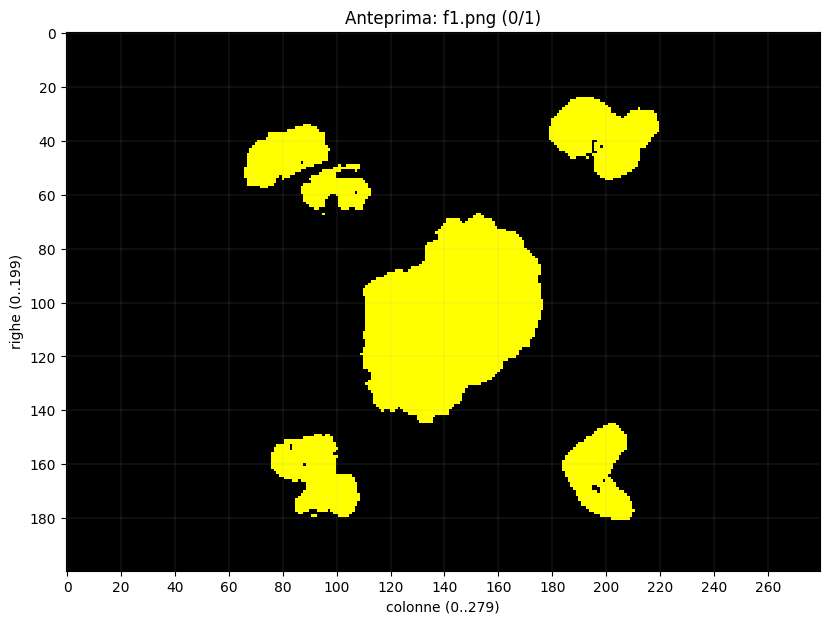

Vuoi usare [r]ighe o [c]olonne? (r/c, default=r):  r
Inserisci indici di RIGHE (es: 0,5,10-20). Range: 0..199:  # 24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199


Indici selezionati: [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] ...


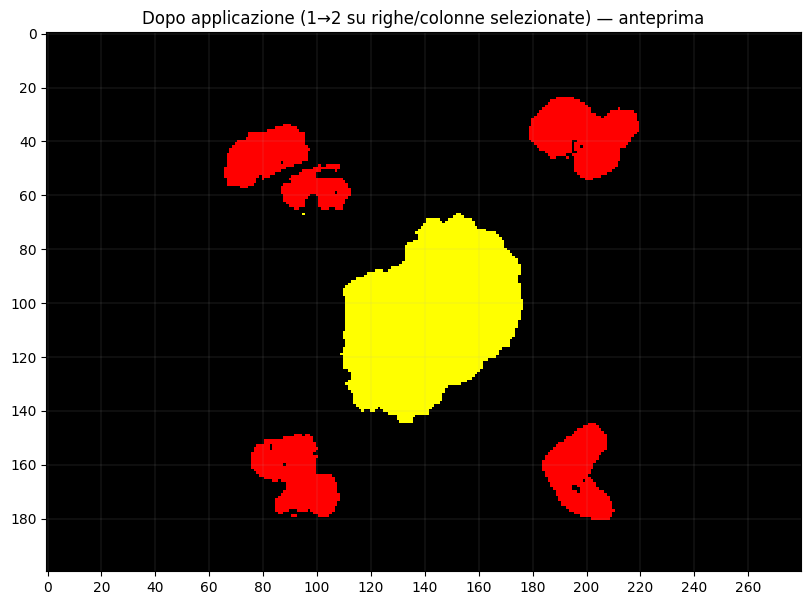


Scelta salvata. Ora esegui la CELLA 2 per creare i dataset e addestrare KNN/CNN.


In [3]:
# === CELLA 1: scelta cartella e selezione cibo su prima immagine ===
import os, re, cv2, numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# Dimensioni finali
H, W = (200, 280)

# Soglie HSV per Physarum (giallo-arancio)
LOWER_YELLOW = np.array([15, 50, 50])
UPPER_YELLOW = np.array([40, 255, 255])

def list_test_dirs(base_dir):
    """Ritorna sottocartelle che contengono almeno un .png."""
    out = []
    for name in sorted(os.listdir(base_dir)):
        p = os.path.join(base_dir, name)
        if os.path.isdir(p) and any(f.lower().endswith(".png") for f in os.listdir(p)):
            out.append(p)
    return out

def parse_indices(text, max_value):
    """Parsa '0,5,10-20' in lista ordinata di indici validi."""
    if not text.strip():
        return []
    items = re.split(r"[,\s]+", text.strip())
    idx = set()
    for it in items:
        if "-" in it:
            try:
                a, b = it.split("-", 1)
                a, b = int(a), int(b)
                if a > b: a, b = b, a
                for v in range(a, b+1):
                    if 0 <= v < max_value: idx.add(v)
            except:
                pass
        else:
            try:
                v = int(it)
                if 0 <= v < max_value: idx.add(v)
            except:
                pass
    return sorted(idx)

def show_mask_with_axes(mask01, title="Anteprima prima immagine (0/1)"):
    """Mostra maschera 0/1 con assi numerati e griglia leggera."""
    cmap = colors.ListedColormap(['black', 'yellow'])
    plt.figure(figsize=(10, 7))
    plt.title(title)
    plt.imshow(mask01, cmap=cmap, vmin=0, vmax=1, interpolation='nearest')
    step_r = max(1, H // 10)
    step_c = max(1, W // 14)
    plt.xticks(np.arange(0, W, step_c))
    plt.yticks(np.arange(0, H, step_r))
    plt.grid(True, linewidth=0.3, alpha=0.4)
    plt.xlabel(f"colonne (0..{W-1})"); plt.ylabel(f"righe (0..{H-1})")
    plt.show()

def to_binary_slime_mask(img_bgr):
    """BGR→HSV→maschera slime 0/1 ridimensionata a (H,W)."""
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, LOWER_YELLOW, UPPER_YELLOW).astype('float32')
    small = cv2.resize(mask, (W, H), interpolation=cv2.INTER_AREA)
    return (small > 50).astype(float)

def apply_food_rows_or_cols(mask_arr, axis_choice, indices):
    """
    Trasforma in 2 tutti i pixel ==1 sulle righe/colonne selezionate.
    Funziona sia su maschere 0/1 che 0/1/2/3 (CNN).
    """
    m = mask_arr.copy()
    if axis_choice == 'r':
        for r in indices:
            row = m[r]
            m[r, row == 1] = 2
    else:  # 'c'
        for c in indices:
            col = m[:, c]
            m[col == 1, c] = 2
    return m

# --- Selezione cartella test ---
BASE_DIR = "/home/n/AILAB/notebooks/ph_test"  # metti qui la cartella che contiene le sottocartelle dei test, se diversa
test_dirs = list_test_dirs(BASE_DIR)
if not test_dirs:
    raise RuntimeError(f"Nessuna sottocartella con .png trovata in: {BASE_DIR}")

print("Cartelle test trovate:")
for i, d in enumerate(test_dirs, 1):
    print(f"  [{i}] {os.path.relpath(d, BASE_DIR)}")

sel = input(f"\nSeleziona un test (1..{len(test_dirs)}) oppure ENTER per [1]: ").strip()
idx = 1 if sel == "" else max(1, min(len(test_dirs), int(sel)))
folder = test_dirs[idx-1]
print(f"\n--> Test selezionato: {folder}")

# --- Carica prima immagine per la scelta ---
files = sorted([f for f in os.listdir(folder) if f.lower().endswith(".png")])
if not files:
    raise RuntimeError("Nessuna .png trovata nella cartella selezionata.")

first_path = os.path.join(folder, files[0])
img0 = cv2.imread(first_path)
if img0 is None:
    raise RuntimeError(f"Impossibile leggere: {first_path}")

mask0 = to_binary_slime_mask(img0)  # 0/1
show_mask_with_axes(mask0, title=f"Anteprima: {os.path.basename(first_path)} (0/1)")

# --- Scelta r/c e indici ---
while True:
    FOOD_AXIS_CHOICE = (input("Vuoi usare [r]ighe o [c]olonne? (r/c, default=r): ").strip().lower() or "r")
    if FOOD_AXIS_CHOICE in ("r", "c"):
        break
    print("Scelta non valida. Digita 'r' oppure 'c'.")

if FOOD_AXIS_CHOICE == "r":
    raw = input(f"Inserisci indici di RIGHE (es: 0,5,10-20). Range: 0..{H-1}: ").strip()
    FOOD_INDICES = parse_indices(raw, H)
else:
    raw = input(f"Inserisci indici di COLONNE (es: 24-65,145-199). Range: 0..{W-1}: ").strip()
    FOOD_INDICES = parse_indices(raw, W)

print(f"Indici selezionati: {FOOD_INDICES[:12]}{' ...' if len(FOOD_INDICES)>12 else ''}")

# Anteprima effetto (solo sulla prima immagine, 1→2)
mask0_preview = apply_food_rows_or_cols(mask0, FOOD_AXIS_CHOICE, FOOD_INDICES)
cmap3 = colors.ListedColormap(['black', 'yellow', 'red'])
norm3 = colors.BoundaryNorm([0, 0.5, 1.5, 2.5], cmap3.N)
plt.figure(figsize=(10,7))
plt.title("Dopo applicazione (1→2 su righe/colonne selezionate) — anteprima")
plt.imshow(mask0_preview, cmap=cmap3, norm=norm3, interpolation='nearest')
step_r = max(1, H // 10); step_c = max(1, W // 14)
plt.xticks(np.arange(0, W, step_c)); plt.yticks(np.arange(0, H, step_r))
plt.grid(True, linewidth=0.3, alpha=0.4)
plt.show()

print("\nScelta salvata. Ora esegui la CELLA 2 per creare i dataset e addestrare KNN/CNN.")

# 24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199


Using device: cpu

[ KNN ] Processing images...
  Processed f1.png
  Processed f2.png
  Processed f3.png
  Processed f4.png
  Processed f5.png
  Processed f6.png
  Processed f7.png
  Processed f8.png
Dataset shape: (8, 200, 280)
X shape: (7, 200, 280)  | y shape: (7, 200, 280)

STARTING KNN ALGORITHM
Training KNN with k=3...
KNN training complete!
Showing KNN predictions for all 7 frames...


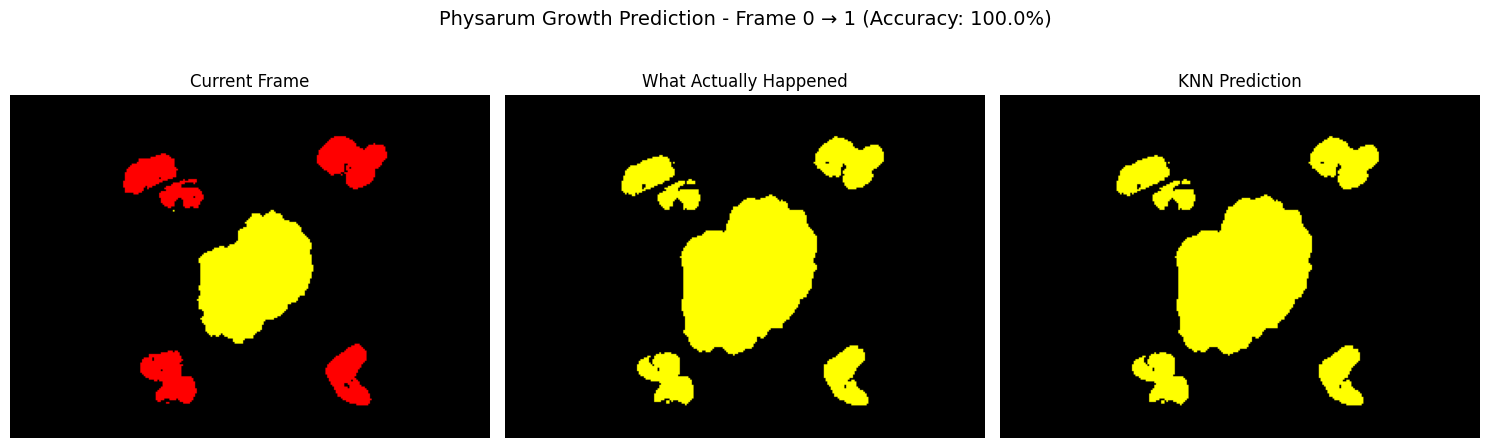

Frame 0: Prediction accuracy = 100.0%


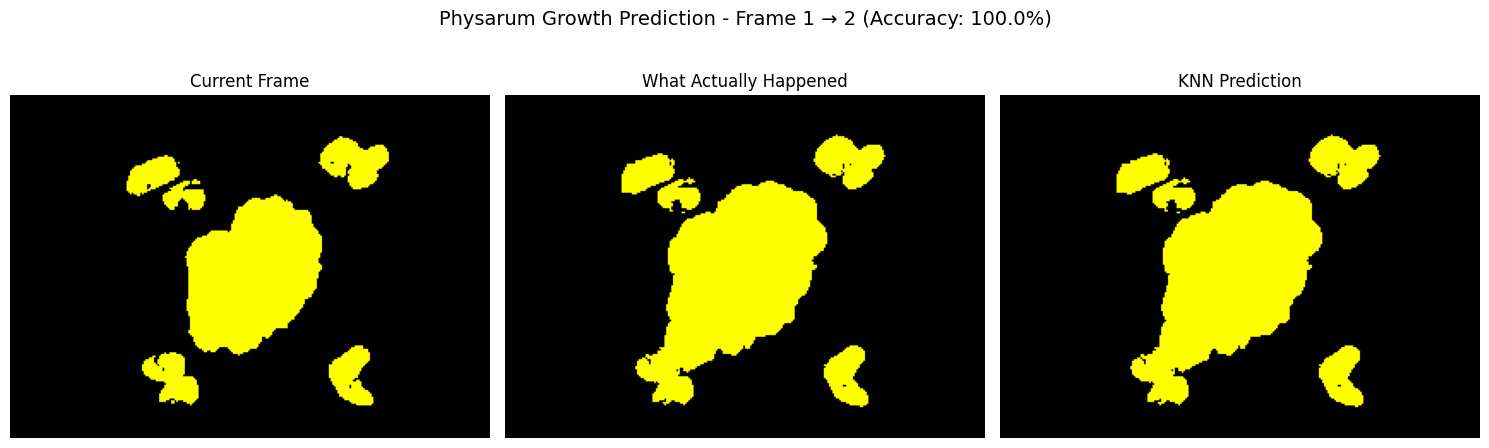

Frame 1: Prediction accuracy = 100.0%


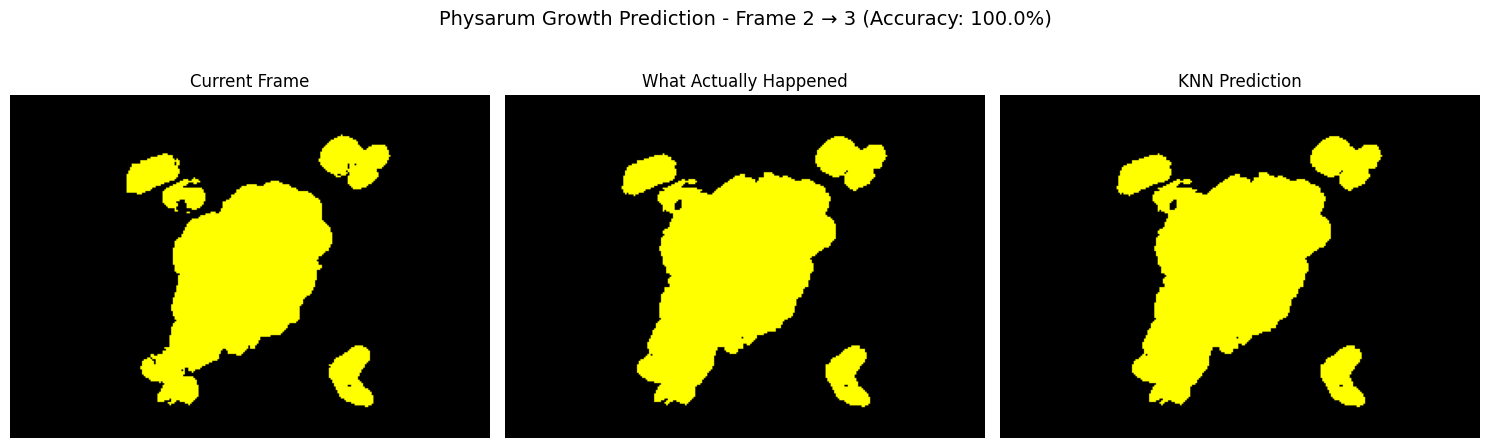

Frame 2: Prediction accuracy = 100.0%


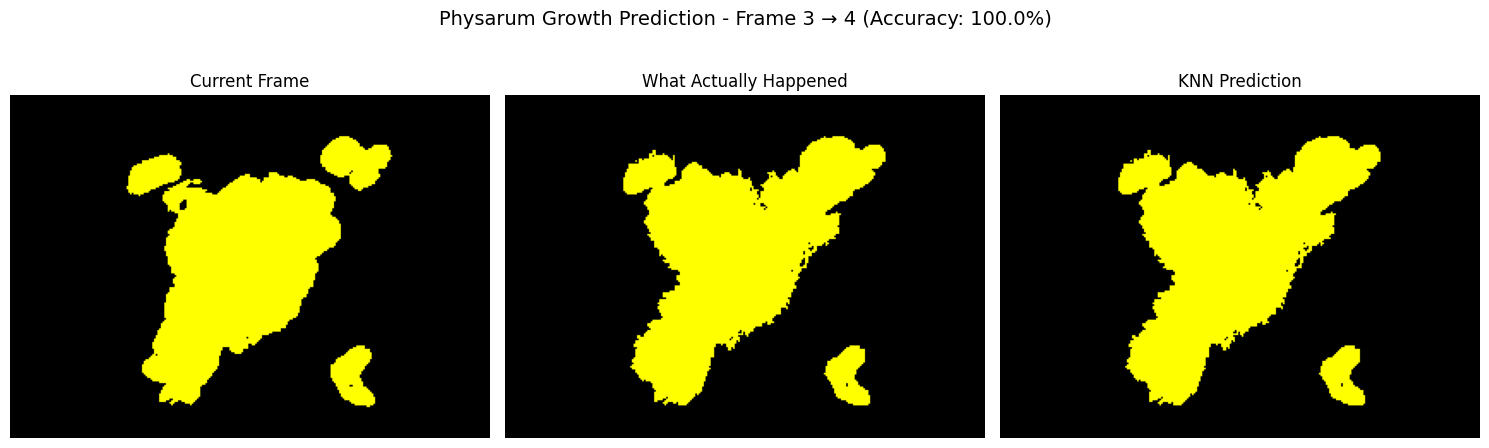

Frame 3: Prediction accuracy = 100.0%


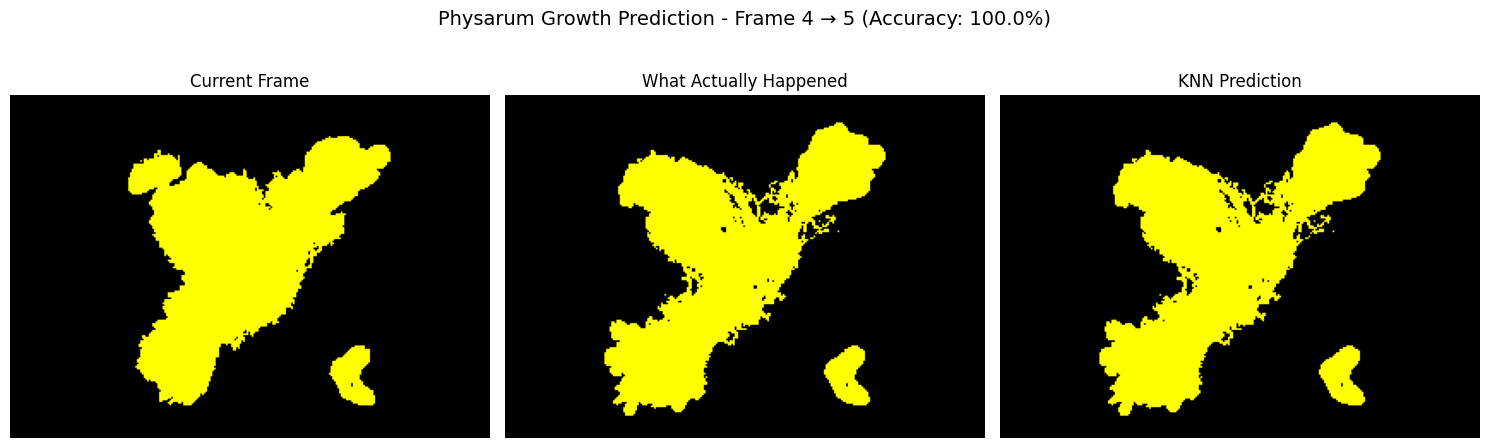

Frame 4: Prediction accuracy = 100.0%


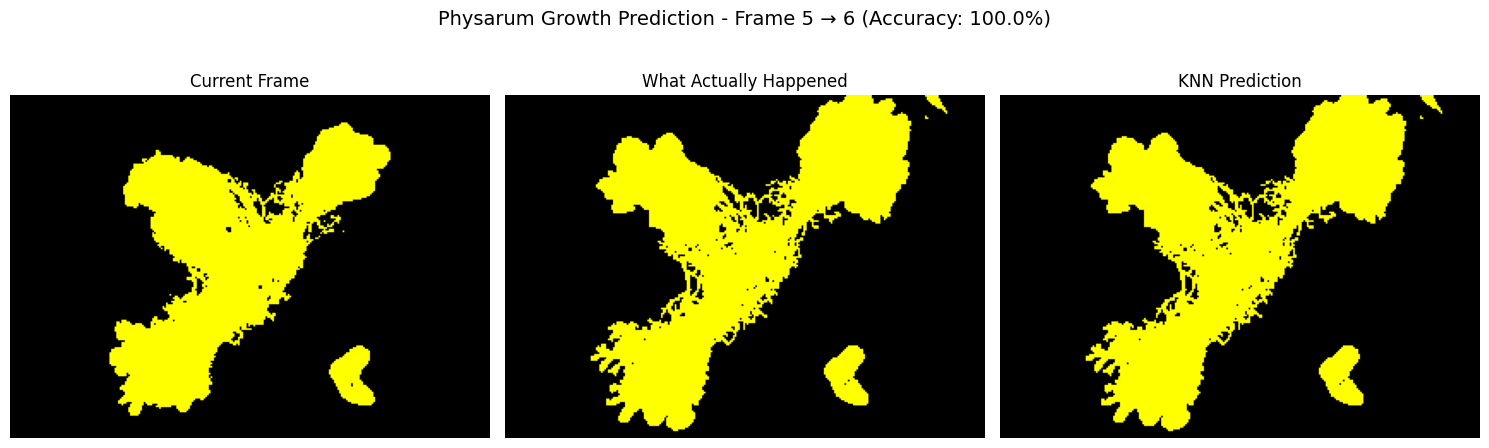

Frame 5: Prediction accuracy = 100.0%


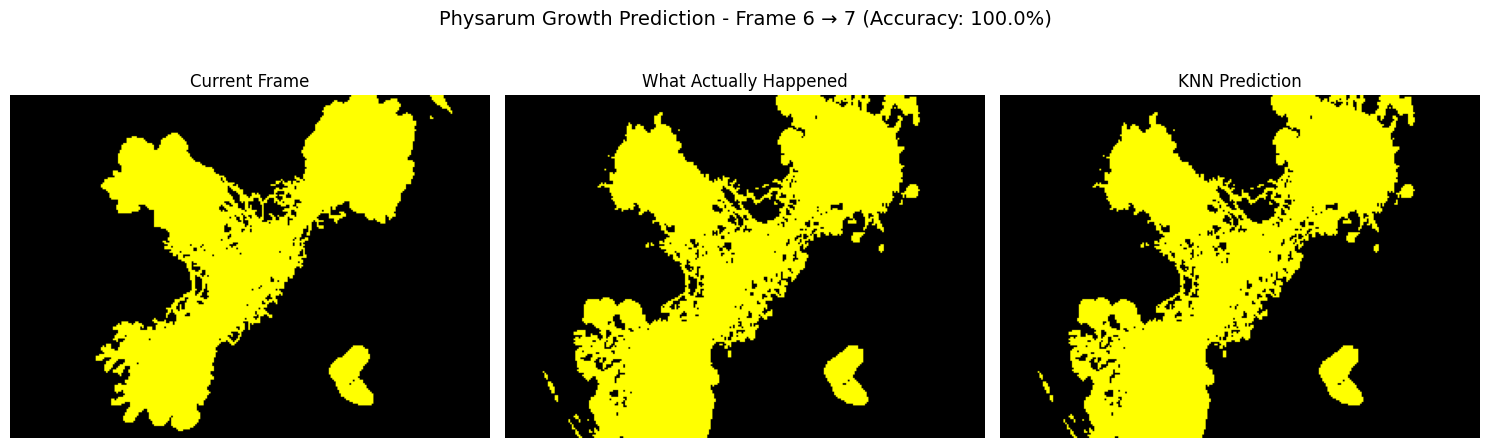

Frame 6: Prediction accuracy = 100.0%

STARTING CNN ALGORITHM
Processing images with biological component separation...
Detecting: Background (black), Physarum (yellow), Food (red), Oat (brown)
CNN Dataset shape: (8, 200, 280)
CNN X shape: (7, 200, 280)  | CNN y shape: (7, 200, 280)

=== CNN BENCHMARK ===

Training Enhanced CNN for 10 epochs...
Epoch 0/10  Loss: 0.0226
Epoch 2/10  Loss: 0.0108
Epoch 4/10  Loss: 0.0102
Epoch 6/10  Loss: 0.0100
Epoch 8/10  Loss: 0.0098
Enhanced CNN training complete!
CNN predicted frame 1/7, range: 0.000-1.076
CNN predicted frame 2/7, range: 0.000-1.149
CNN predicted frame 3/7, range: 0.000-1.170
CNN predicted frame 4/7, range: 0.000-1.170
CNN predicted frame 5/7, range: 0.000-1.192
CNN predicted frame 6/7, range: 0.000-1.163
CNN predicted frame 7/7, range: 0.000-1.062

=== CNN RESULTS ===


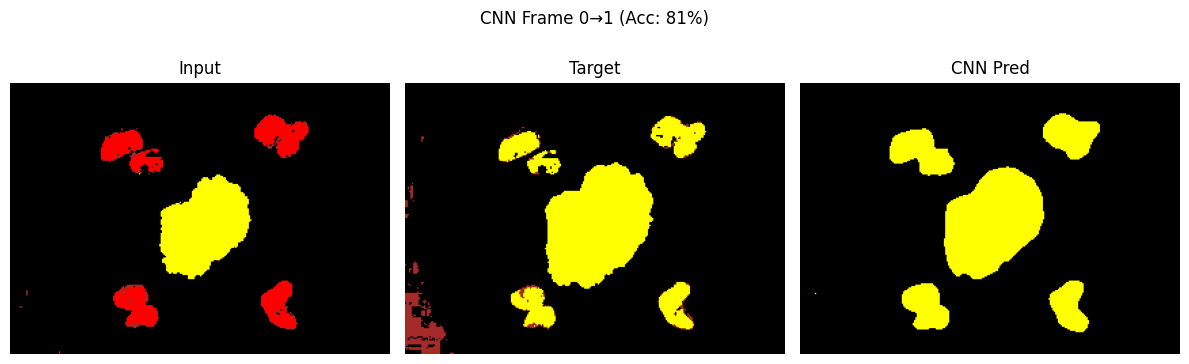

Frame 0: CNN 81% accuracy


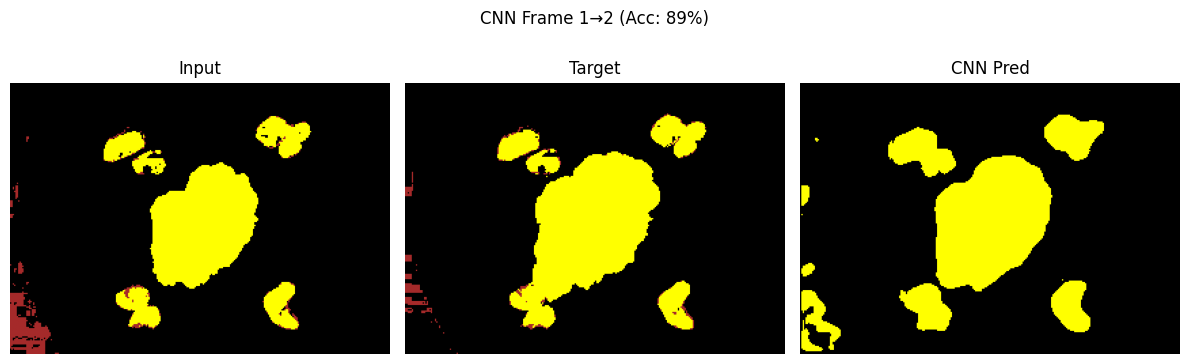

Frame 1: CNN 89% accuracy


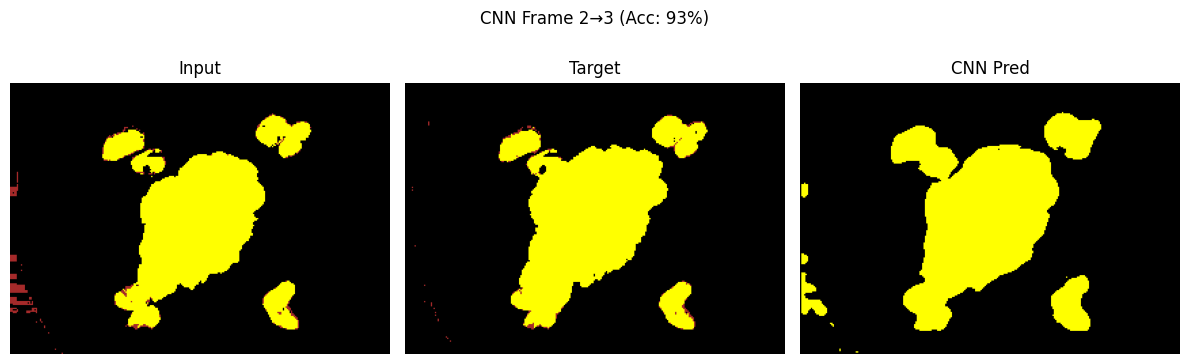

Frame 2: CNN 93% accuracy


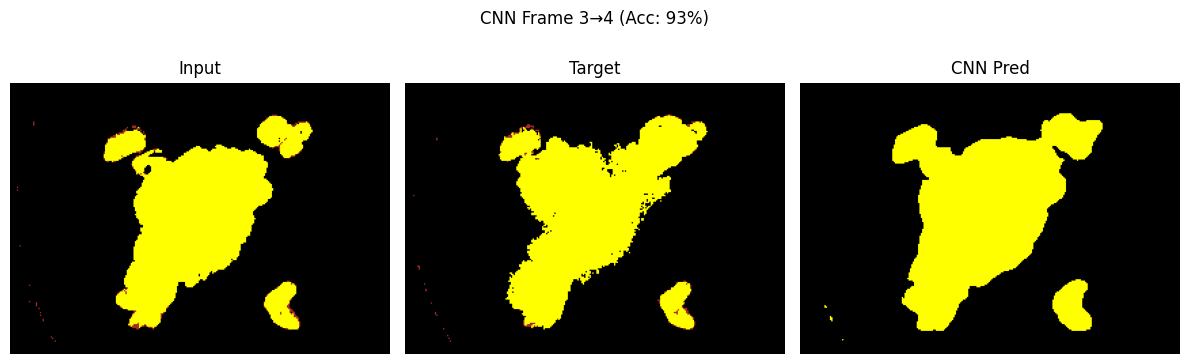

Frame 3: CNN 93% accuracy


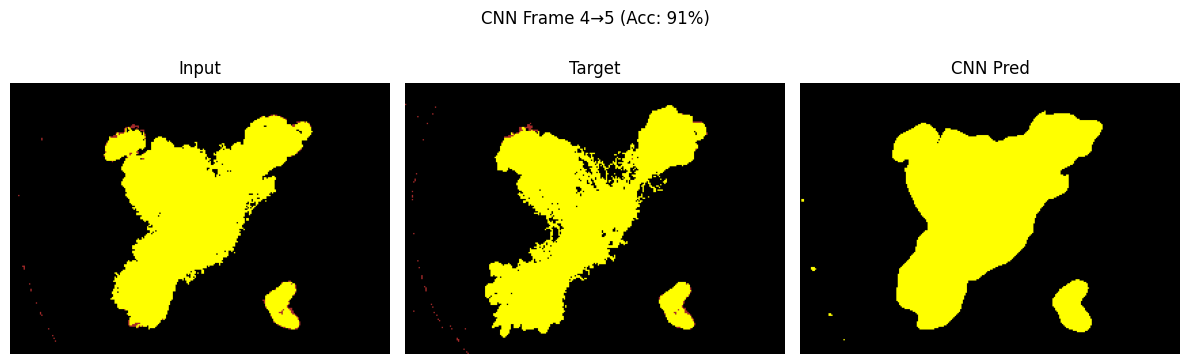

Frame 4: CNN 91% accuracy


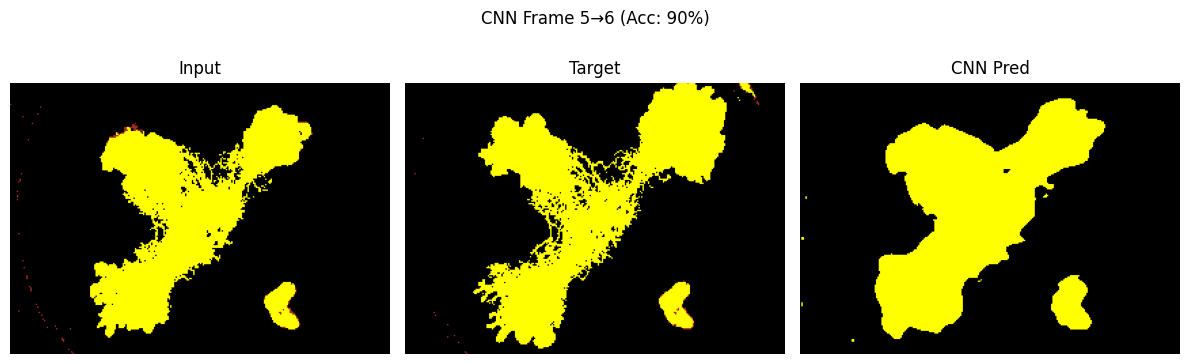

Frame 5: CNN 90% accuracy


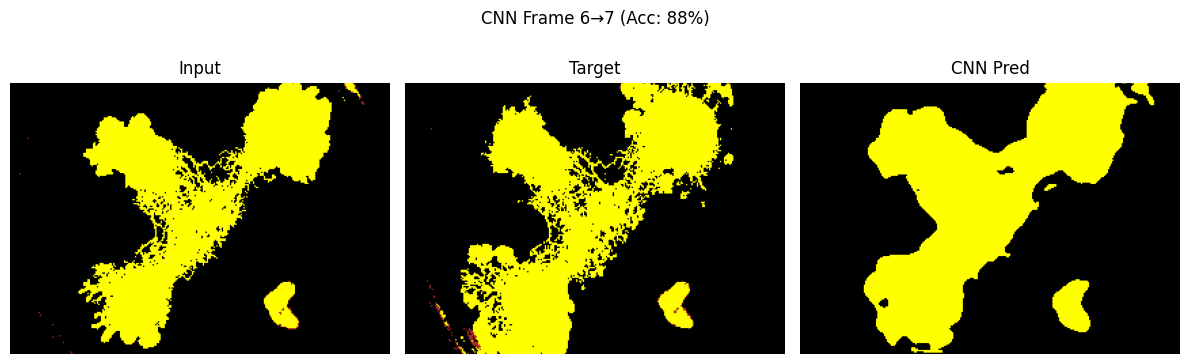

Frame 6: CNN 88% accuracy

STARTING MLP ALGORITHM

Training MLP for 10 epochs...
Epoch 0/10  Loss: 0.0870
Epoch 2/10  Loss: 0.0261
Epoch 4/10  Loss: 0.0172
Epoch 6/10  Loss: 0.0144
Epoch 8/10  Loss: 0.0133

MLP


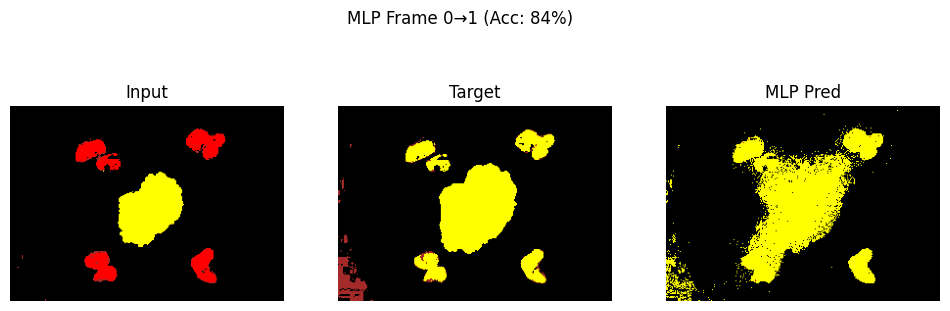

Frame 0: MLP 84% accuracy


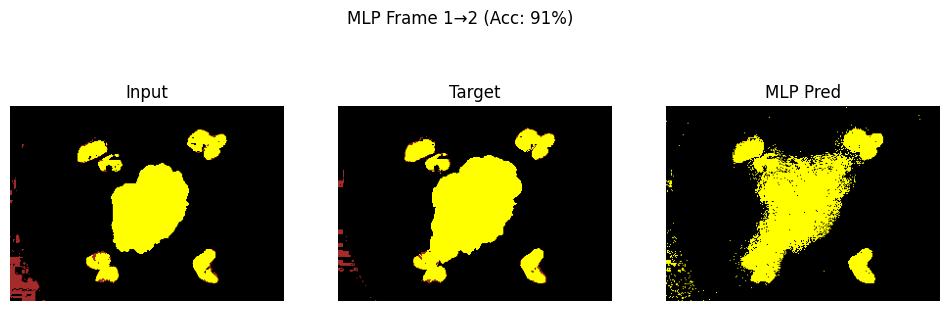

Frame 1: MLP 91% accuracy


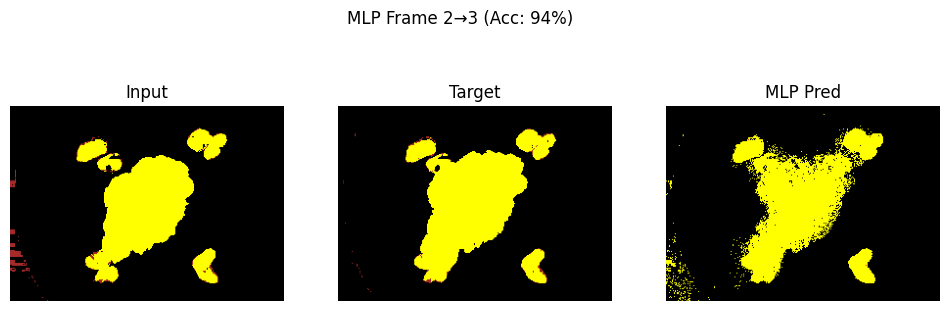

Frame 2: MLP 94% accuracy


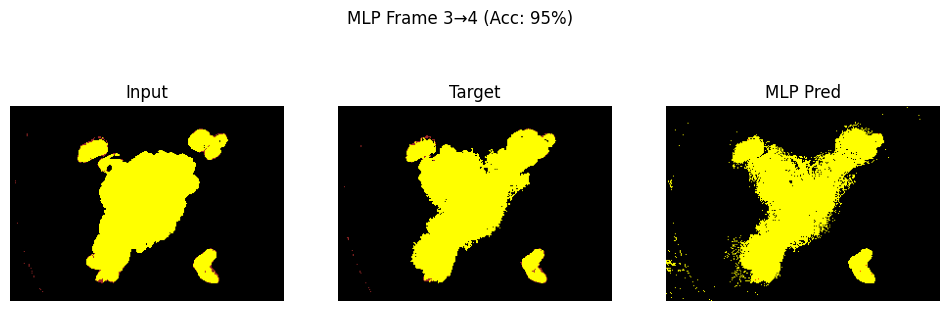

Frame 3: MLP 95% accuracy


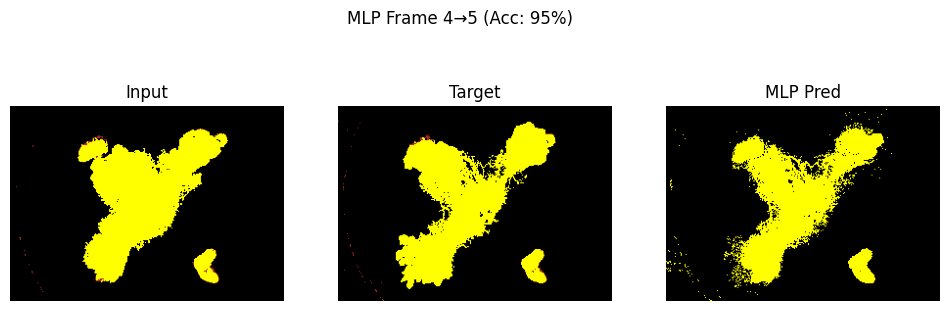

Frame 4: MLP 95% accuracy


In [4]:
# === CELLA 2: crea dataset e addestra KNN + CNN usando la scelta della Cella 1 ===
import numpy as np, cv2, os, matplotlib.pyplot as plt
from matplotlib import colors
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import NearestNeighbors

# Safety: fallback se qualcuno ha saltato la cella 1
assert 'folder' in globals() and 'files' in globals(), "Esegui prima la Cella 1 (selezione test e cibo)."
FOOD_AXIS_CHOICE = globals().get('FOOD_AXIS_CHOICE', None)
FOOD_INDICES = globals().get('FOOD_INDICES', [])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ---------- DATASET per KNN ----------
dataset = []
print("\n[ KNN ] Processing images...")
for i, file in enumerate(files):
    path = os.path.join(folder, file)
    img = cv2.imread(path)
    if img is None:
        print(f"  [SKIP] {path}")
        continue
    mask_small = to_binary_slime_mask(img)  # 0/1
    if i == 0 and FOOD_INDICES:
        mask_small = apply_food_rows_or_cols(mask_small, FOOD_AXIS_CHOICE, FOOD_INDICES)
    dataset.append(mask_small)
    print(f"  Processed {file}")

dataset = np.array(dataset)
print("Dataset shape:", dataset.shape)

X = dataset[:-1]  # input: t=0..n-2
y = dataset[1:]   # target: t=1..n-1
print("X shape:", X.shape, " | y shape:", y.shape)

# ---------- KNN ----------
print("\n" + "="*60)
print("STARTING KNN ALGORITHM")
print("="*60)

class PhysarumKNN:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
        self.knn = NearestNeighbors(n_neighbors=k, metric='cosine')
    def fit(self, X, y):
        print(f"Training KNN with k={self.k}...")
        self.X_train = X.reshape(X.shape[0], -1)
        self.y_train = y
        self.knn.fit(self.X_train)
        print("KNN training complete!")
    def predict_single(self, input_frame):
        input_flat = input_frame.reshape(1, -1)
        distances, indices = self.knn.kneighbors(input_flat)
        neighbor_indices = indices.flatten()
        neighbor_next_frames = self.y_train[neighbor_indices]
        neighbor_distances = distances.flatten()
        weights = 1.0 / (neighbor_distances + 1e-8)
        weights = weights / np.sum(weights)
        prediction = np.average(neighbor_next_frames, axis=0, weights=weights)
        return prediction, neighbor_indices, neighbor_distances

def show_knn_results(model, X, y, max_samples=5):
    cmap = colors.ListedColormap(['black', 'yellow', 'red'])
    norm = colors.BoundaryNorm([0, 0.5, 1.5, 2.5], cmap.N)
    for i in range(min(len(X), max_samples)):
        input_frame = X[i]
        target_frame = y[i]
        prediction, _, _ = model.predict_single(input_frame)
        mse = np.mean((prediction - target_frame)**2)
        accuracy = max(0, 100 * (1 - mse))
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Physarum Growth Prediction - Frame {i} → {i+1} (Accuracy: {accuracy:.1f}%)", fontsize=14)
        plt.subplot(1, 3, 1); plt.title("Current Frame"); plt.imshow(input_frame, cmap=cmap, norm=norm); plt.axis('off')
        plt.subplot(1, 3, 2); plt.title("What Actually Happened"); plt.imshow(target_frame, cmap=cmap, norm=norm); plt.axis('off')
        plt.subplot(1, 3, 3); plt.title("KNN Prediction"); plt.imshow(prediction, cmap=cmap, norm=norm); plt.axis('off')
        plt.tight_layout(); plt.show()
        print(f"Frame {i}: Prediction accuracy = {accuracy:.1f}%")

model = PhysarumKNN(k=3)
model.fit(X, y)
print("=" * 40)
print(f"Showing KNN predictions for all {len(X)} frames...")
show_knn_results(model, X, y, max_samples=len(X))

########## datast
print("\n" + "="*60)
print("STARTING CNN ALGORITHM")
print("="*60)
print("Processing images with biological component separation...")
print("Detecting: Background (black), Physarum (yellow), Food (red), Oat (brown)")

dataset_cnn = []
for i, file in enumerate(files):
    path = os.path.join(folder, file)
    img = cv2.imread(path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_physarum = np.array([15, 50, 50])
    upper_physarum = np.array([40, 255, 255])
    physarum_mask = cv2.inRange(hsv, lower_physarum, upper_physarum)
    lower_oat = np.array([10, 30, 30])
    upper_oat = np.array([25, 255, 200])
    oat_mask = cv2.inRange(hsv, lower_oat, upper_oat)
    oat_mask = cv2.bitwise_and(oat_mask, cv2.bitwise_not(physarum_mask))
    mask_combined = np.zeros_like(physarum_mask, dtype=np.float32)
    mask_combined[physarum_mask > 0] = 1.0  # Physarum = 1
    mask_combined[oat_mask > 0] = 3.0       # Oat = 3
    mask_small = cv2.resize(mask_combined, (W, H), interpolation=cv2.INTER_NEAREST).astype(float)

    # Applica la STESSA scelta cibo (1→2) sulla prima immagine
    if i == 0 and FOOD_INDICES:
        mask_small = apply_food_rows_or_cols(mask_small, FOOD_AXIS_CHOICE, FOOD_INDICES)

    dataset_cnn.append(mask_small)

dataset_cnn = np.array(dataset_cnn)
print("CNN Dataset shape:", dataset_cnn.shape)

# Normalizza a 0..1 per la CNN (max 3)
dataset_norm = dataset_cnn / 3.0
X_cnn = dataset_norm[:-1]
y_cnn = dataset_norm[1:]
print("CNN X shape:", X_cnn.shape, " | CNN y shape:", y_cnn.shape)

########################
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding=2), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 1, 1)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

class PhysarumDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X).unsqueeze(1)
        self.y = torch.FloatTensor(y).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

def train_cnn(X, y, epochs=10):
    print(f"\nTraining Enhanced CNN for {epochs} epochs...")
    train_loader = DataLoader(PhysarumDataset(X, y), batch_size=1, shuffle=True)
    model = SimpleCNN().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for bx, by in train_loader:
            bx, by = bx.to(device), by.to(device)
            optimizer.zero_grad()
            pred = model(bx)
            loss = criterion(pred, by)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg = total_loss/len(train_loader)
        losses.append(avg)
        if epoch % 2 == 0:
            print(f"Epoch {epoch}/{epochs}  Loss: {avg:.4f}")
    print("Enhanced CNN training complete!")
    return model, losses


def predict_with_cnn(model, X):
    model.eval(); out = []
    with torch.no_grad():
        for i, frame in enumerate(X):
            tensor = torch.FloatTensor(frame).unsqueeze(0).unsqueeze(0).to(device)
            pred = model(tensor).cpu().numpy().squeeze()
            pred = np.abs(pred); pred = np.clip(pred, 0, 1); pred = pred * 3.0
            out.append(pred)
            print(f"CNN predicted frame {i+1}/{len(X)}, range: {pred.min():.3f}-{pred.max():.3f}")
    return np.array(out)

def show_benchmark_comparison(X, y, cnn_predictions, max_samples=2):
    cmap = colors.ListedColormap(['black', 'yellow', 'red', 'brown'])
    norm = colors.BoundaryNorm([0, 0.5, 1.5, 2.5, 3.5], cmap.N)
    for i in range(min(len(X), max_samples)):
        inp = X[i] * 3.0; tgt = y[i] * 3.0; pred = cnn_predictions[i]
        mse = np.mean((pred - tgt)**2); acc = max(0, 100 * (1 - mse))
        plt.figure(figsize=(12,4)); plt.suptitle(f"CNN Frame {i}→{i+1} (Acc: {acc:.0f}%)")
        plt.subplot(1,3,1); plt.title("Input"); plt.imshow(inp, cmap=cmap, norm=norm); plt.axis('off')
        plt.subplot(1,3,2); plt.title("Target"); plt.imshow(tgt, cmap=cmap, norm=norm); plt.axis('off')
        plt.subplot(1,3,3); plt.title("CNN Pred"); plt.imshow(pred, cmap=cmap, norm=norm); plt.axis('off')
        plt.tight_layout(); plt.show()
        print(f"Frame {i}: CNN {acc:.0f}% accuracy")

print("\n=== CNN BENCHMARK ===")
cnn_model, cnn_losses = train_cnn(X_cnn, y_cnn, epochs=10)
cnn_predictions = predict_with_cnn(cnn_model, X_cnn)


print("\n=== CNN RESULTS ===")
show_benchmark_comparison(X_cnn, y_cnn, cnn_predictions, max_samples=len(X_cnn))

avg_cnn_accuracy = np.mean([
    max(0, 100*(1 - np.mean((cnn_predictions[i] - (y_cnn[i]*3.0))**2)))
    for i in range(len(X_cnn))
])

###########
print("\n" + "="*60)
print("STARTING MLP ALGORITHM")
print("="*60)

# Prepariamo i dati per MLP (flatten)
X_mlp = X_cnn.reshape(len(X_cnn), -1)   # shape: (n-1, H*W)
y_mlp = y_cnn.reshape(len(y_cnn), -1)   # shape: (n-1, H*W)

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size=512, output_size=None):
        super(SimpleMLP, self).__init__()
        if output_size is None:
            output_size = input_size
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.net(x)

def train_mlp(X, y, epochs=5, batch_size=4):
    print(f"\nTraining MLP for {epochs} epochs...")
    dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X), torch.FloatTensor(y)
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    input_size = X.shape[1]
    output_size = y.shape[1]
    model = SimpleMLP(input_size, hidden_size=512, output_size=output_size).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for bx, by in loader:
            bx, by = bx.to(device), by.to(device)
            optimizer.zero_grad()
            pred = model(bx)
            loss = criterion(pred, by)
            loss.backward()
            optimizer.step()
        if epoch % 2 == 0:
            print(f"Epoch {epoch}/{epochs}  Loss: {loss.item():.4f}")
    return model

def predict_with_mlp(model, X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        preds = model(X_tensor).cpu().numpy()
    return preds

# Addestramento MLP
mlp_model = train_mlp(X_mlp, y_mlp, epochs=10)

# Predizioni
mlp_preds_flat = predict_with_mlp(mlp_model, X_mlp)
mlp_preds = mlp_preds_flat.reshape(-1, H, W)

# Visualizzazione confronti
def show_mlp_results(X, y, preds, max_samples=3):
    cmap = colors.ListedColormap(['black', 'yellow', 'red', 'brown'])
    norm = colors.BoundaryNorm([0,0.5,1.5,2.5,3.5], cmap.N)
    for i in range(min(len(X), max_samples)):
        inp = X[i]*3.0
        tgt = y[i]*3.0
        pred = preds[i]*3.0
        mse = np.mean((pred - tgt)**2)
        acc = max(0, 100*(1 - mse))
        plt.figure(figsize=(12,4))
        plt.suptitle(f"MLP Frame {i}→{i+1} (Acc: {acc:.0f}%)")
        plt.subplot(1,3,1); plt.title("Input"); plt.imshow(inp, cmap=cmap, norm=norm); plt.axis('off')
        plt.subplot(1,3,2); plt.title("Target"); plt.imshow(tgt, cmap=cmap, norm=norm); plt.axis('off')
        plt.subplot(1,3,3); plt.title("MLP Pred"); plt.imshow(pred, cmap=cmap, norm=norm); plt.axis('off')
        plt.show()
        print(f"Frame {i}: MLP {acc:.0f}% accuracy")

print("\nMLP")
show_mlp_results(X_cnn, y_cnn, mlp_preds, max_samples=5)

